In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator

rcParams = {
    'xtick.labelsize': 12,
    'axes.titlesize': 22,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12,
    'lines.linewidth': 2
}
sns.set_context("paper", font_scale=2, rc=rcParams)

In [2]:
variable_names = {
    **{f'X{i}': f'X_{i}' for i in range(9)},
    'Z00': 'Z_{syn}',
    'Z01': 'Z_{red}',
    'Z_syn': 'Z_{syn}',
    'Z_red': 'Z_{red}',
    'Zxor': 'Z_{xor}'
}

methods = ['THOI', 'JIDT']

method_colors = {
    m:c for m,c in zip(['THOI','JIDT'], sns.color_palette('muted', 2))
}

def format_nplet_name(nplet):
    variables = nplet.split('-')
    variables = [variable_names[v] for v in variables]
    return fr'$({",".join(variables)})$'

In [3]:
def plot_heatmap(df, dim1, dim2, ax, **kargs):

    # Pivot the data to get a matrix form suitable for heatmap plotting
    pivot_table = df.pivot(columns=dim1, index=dim2, values="O-information")

    # Create the heatmap
    ax = sns.heatmap(
        pivot_table, cmap="vlag", center=0, ax=ax,
        annot=False, cbar=False,
        **kargs
    )

    ax.tick_params(axis='x', rotation=90)
    ax.set_aspect('equal','box')
    ax.tick_params(left=False, bottom=False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ticks = [0.5,3.5,5.5,7.5,10.5]
    tick_labels = ['0.01', '0.3', '0.5', '0.7', '1.0']
    
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(tick_labels, rotation=90, ha='center')
    ax.set_yticklabels(tick_labels)


def plot_o_info_heatmap(df, system):

    nplets = df['n-plet'].unique()

    # set figure size
    n_methods = len(methods)
    n_nplets = len(nplets)
    fig_width = 4.6*n_methods
    fig_height = 5.0*n_nplets
    fig, axes = plt.subplots(
        n_nplets, n_methods,
        figsize=(fig_width, fig_height),
        sharex=True, sharey=True
    )

    if n_nplets == 1:
        axes = np.array([axes]) # for shape compatibility

    for nplet_axes, nplet in zip(axes, nplets):
        df_nplet = df[df['n-plet'] == nplet]
        for ax, method in zip(nplet_axes, methods):
            df_method = df_nplet[df_nplet['method'] == method]
            plot_heatmap(df_method, 'alpha', 'beta', ax)
    
    for ax in axes[:,0].flatten():
        ax.set_ylabel(r'$\beta$')
        
    for ax in axes[-1]:
        ax.set_xlabel(r'$\alpha$')
        
    for ax, method in zip(axes[0], methods):
        ax.set_title(method, pad=10)
        
    plt.tight_layout(rect=[0.06, 0, 1, 1])

    for i, nplet in enumerate(nplets):
        ax = axes[i,0]
        y_label_pos = ax.yaxis.label.get_position()[1]
        bbox = ax.get_position()
        y_position = bbox.y0 + y_label_pos * bbox.height
        fig.text(0.06, y_position,
                 format_nplet_name(nplet), ha='center', va='center',
                 rotation='vertical', fontsize=28)

    plt.savefig(f'./figures/o_info/system-{system}_heatmap.pdf', format='pdf')
    plt.show()

In [4]:
def plot_o_info_linear(df, system, axes=None, remove_beta=True, figsize=None, ylabel=r'$\Omega (\alpha)$', custom=None):

    # Keep for all values of alpha, only the value of beta == 1-alpha
    if remove_beta:
        df = df[abs((1 - df.alpha) - df.beta) < 0.001]

    if axes is None:
        n_nplets = len(df['n-plet'].unique())
        
        if figsize is None:
            fig_width = 5.0 * n_nplets
            fig_height = 6.0
            figsize = (fig_width, fig_height)

        fig, axes = plt.subplots(1, n_nplets, figsize=figsize, sharex=True)

        if n_nplets == 1:
            axes = np.array([axes])  # For shape compatibility

        axes = axes.reshape(1,-1)

    for ax, (nplet, df_nplet) in zip(axes.flatten(), df.groupby('n-plet')):
        sns.lineplot(
            df_nplet, x='alpha', y='O-information', hue='method',
            hue_order=methods, palette=method_colors, ax=ax
        )

        ax.set_xlim(0, 1)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
        ax.hlines(0, xmin=0.0, xmax=1.0, color='black', linestyles='--')
        
        ax.set_title(format_nplet_name(nplet), pad=10)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.grid(True)
        ax.get_legend().remove()

    for axes_row in axes:
        axes_row[0].set_ylabel(ylabel)

    if axes.shape[1] == 3:
        axes[-1,1].set_xlabel(r'$\alpha$')
    else:
        [ax.set_xlabel(r'$\alpha$') for ax in axes[-1]]

    # Create custom legend handles
    legend_elements_gaussian = [
        Line2D([0], [0], color=method_colors['THOI'], lw=2, label='THOI'),
        Line2D([0], [0], color=method_colors['JIDT'], lw=2, label='JIDT')
    ]

    # Position the legends to avoid overlap    
    axes[-1,-1].legend(
        handles=legend_elements_gaussian,
        title='Library',
        loc='upper right',
        bbox_to_anchor=(1., -0.15),
        ncol=2,
        title_fontsize=16
    )

    if custom is not None:
        custom(axes)

    plt.tight_layout()  # Adjust the layout to make room for the legends
    plt.savefig(f'./figures/o_info/system-{system}_lineplot.pdf', format='pdf')
    plt.show()

In [5]:
def read_csv(path):
    df1 = pd.read_csv(path + '.tsv', sep='\t')
    df1 = df1[df1.method == 'THOI']
    df2 = pd.read_csv(path + '_JDIT.tsv', sep='\t')

    #df_gcmi = df1[df1.method == 'GCMI'].copy()
    #df_gcmi['O-information'] *= np.log(2)
    #df1 = df1[df1.method != 'GCMI']

    #return pd.concat([df1, df2, df_gcmi])
    return pd.concat([df1, df2])

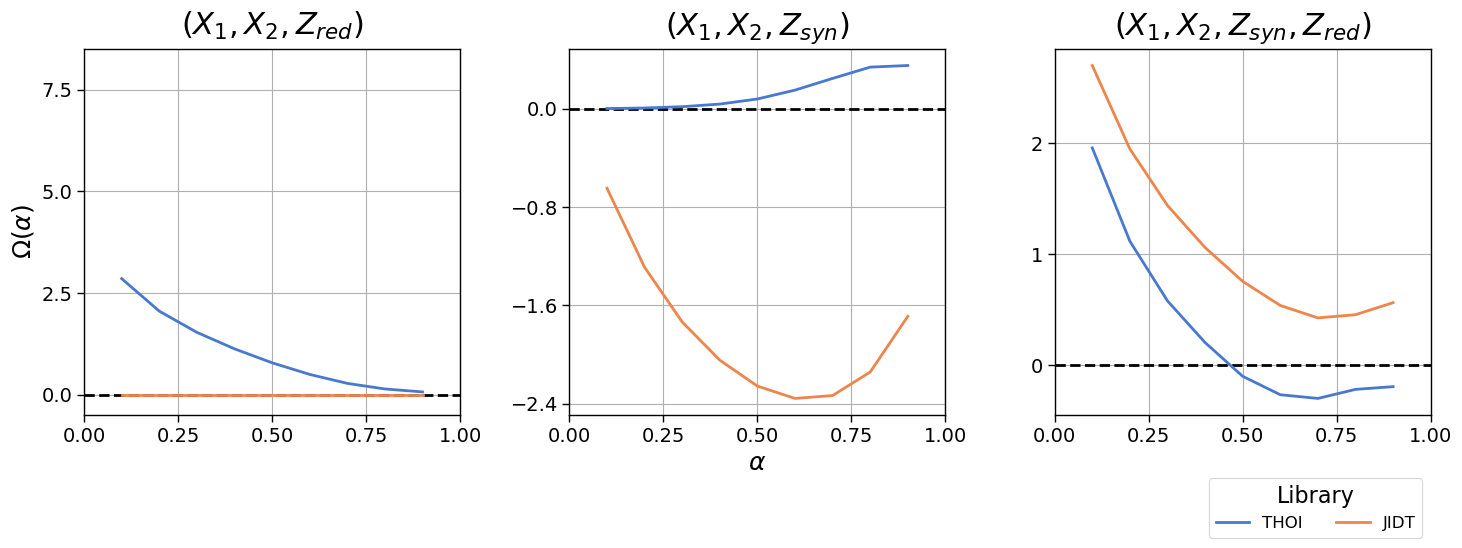

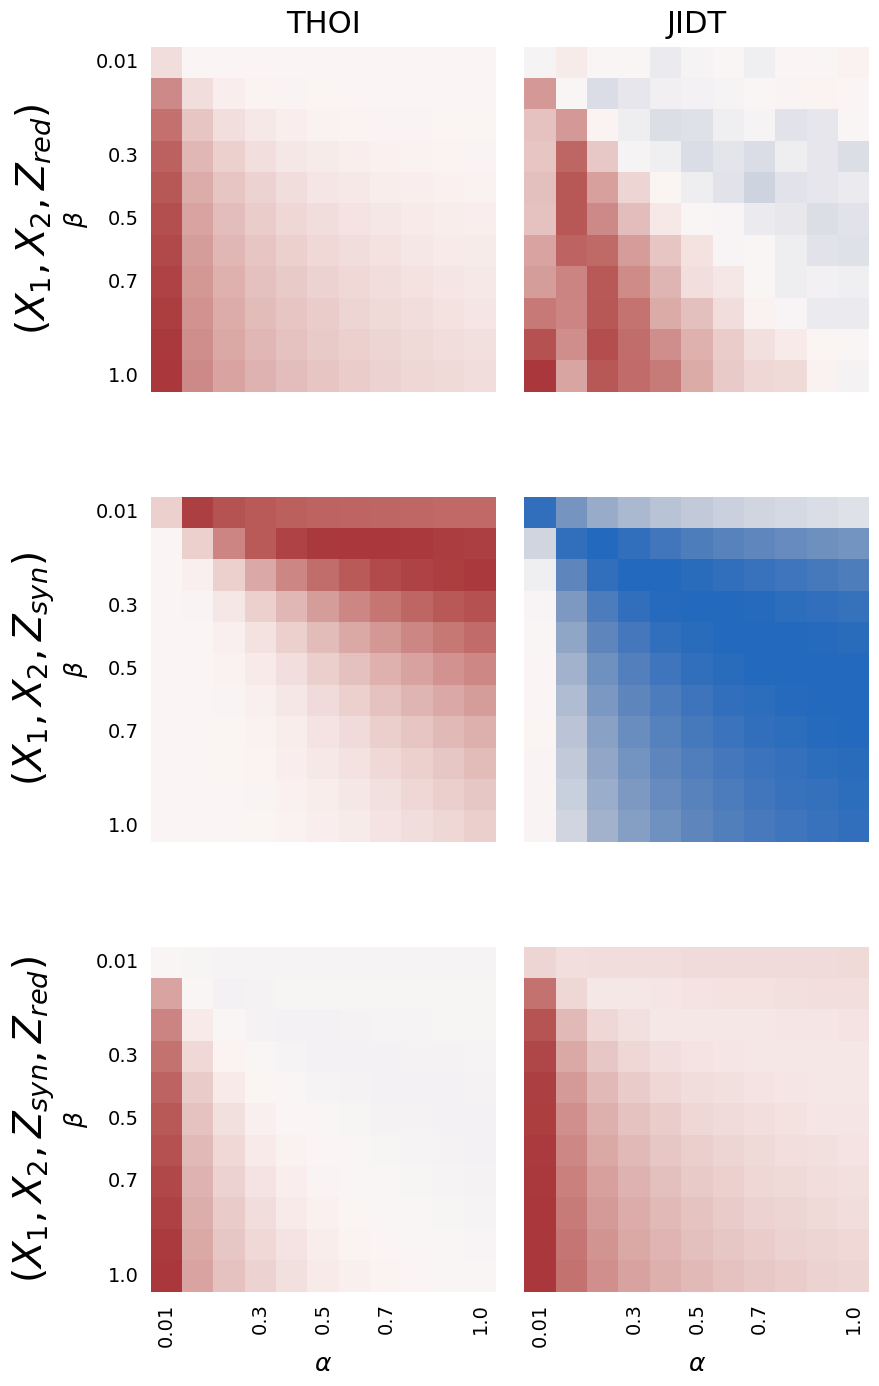

In [6]:
df = read_csv('../benchmarking/results/o_info/system-relu_pow-0.5_repeat-20_t-10000')

def set_y_lim(axes):
    axes.flatten()[0].set_ylim(-0.5, 8.5)

plot_o_info_linear(df, 'relu_pow-0.5', custom=set_y_lim)
plot_o_info_heatmap(df, 'relu_pow-0.5')

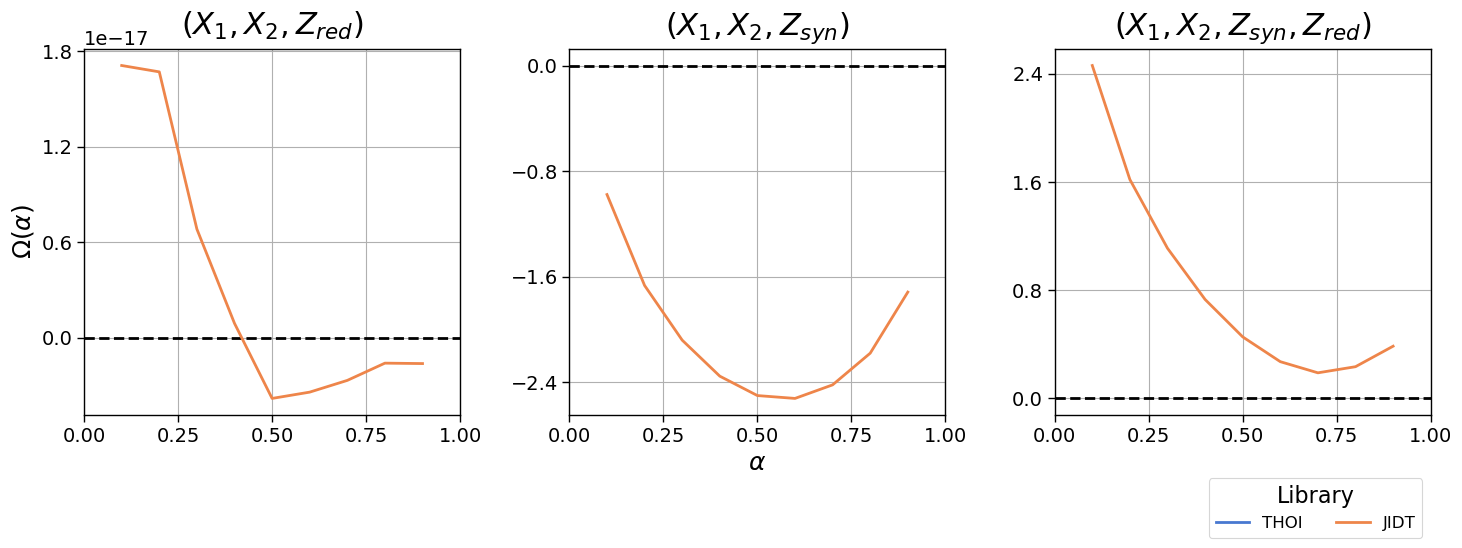

In [7]:
df = read_csv('../benchmarking/results/o_info/system-relu_pow-1.0_repeat-20_t-10000')
df = df[df['method'] == 'JIDT']


plot_o_info_linear(df, 'relu_pow-1.0_zoom')

  0%|          | 0/10 [00:00<?, ?it/s]

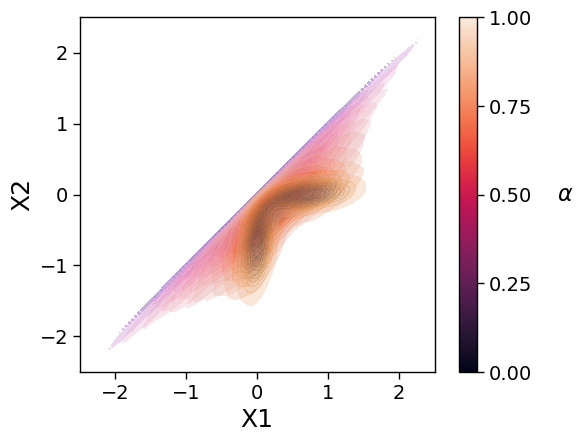

In [8]:
from tqdm.notebook import tqdm

def ReLU(X, cutoff=0):
    return np.maximum(X,cutoff)


def generate_relu_sistem(alpha: float=1.0, beta: float=1.0, pow_factor: float=0.5, T: float=10000):

    assert 0 <= alpha <= 1.0, 'alpha must be in range [0,1]'
    assert 0 <= beta <= 1.0, 'beta must be in range [0,1]'

    Z_syn, Z_red = np.random.normal(0, 1, (2,T))

    X1 = alpha*np.power(ReLU(Z_syn), pow_factor)    + beta*Z_red
    X2 = -alpha*np.power(ReLU(-Z_syn), pow_factor)  + beta*Z_red

    return pd.DataFrame({'X1': X1, 'X2': X2, 'Z_syn': Z_syn, 'Z_red': Z_red})

# get color pallet for 10 items in a cmap
palette = sns.color_palette('rocket', 10) 
ax = plt.gca()
datas = []
for i, alpha in enumerate(tqdm(np.arange(0.01, 1.002, 0.1))):
    data = generate_relu_sistem(alpha=alpha, beta=(1-alpha), pow_factor=0.5)
    sns.kdeplot(data=data, x='X1', y='X2', fill=True, color=palette[i], alpha=max(0.3, 1/(i+1)), ax=ax)

# add a colorbar with the color palette range
sm = plt.cm.ScalarMappable(cmap='rocket', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.arange(0,1.1,0.25))
cbar.ax.set_ylabel(r'$\alpha$', rotation=0, va='center', labelpad=24, fontsize=16)

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('./figures/systems/system-ReLU_power-0.5.pdf', format='pdf')
plt.show()